In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import nipype
import nipype.interfaces.spm as spm
import sys
import shutil
import numpy as np

from nipype.algorithms import modelgen
from nipype.interfaces.base import Bunch
from nipype.algorithms import modelgen
from nipype.interfaces.spm.model import Level1Design
import nipype.interfaces.spm.utils as spmu

import nibabel as nib
import numpy as np

from nilearn import plotting
from nilearn.image import mean_img
from nilearn.plotting import plot_stat_map

def print_fname(func):
    def wrapper(*args, **kwargs):
        res = func(*args, **kwargs)
        print(f"{func.__name__.upper()} DONE")
        return res
    return wrapper
            

221016-21:21:16,540 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


### Подготовка данных

In [9]:
@print_fname
def dicom_import(files, output_dir):
    di = spmu.DicomImport()
    di.inputs.in_files = files
    di.inputs.output_dir = output_dir
    di.inputs.output_dir_struct = 'series'
    return di.run() 

def dcm_imports(nifty_dir, dcm_dir):
    """
    Converts dicom files to nifty files
    """
    pat_files = {}
    for folder in os.listdir(dcm_dir):
        abs_folder = os.path.join(dcm_dir, folder)
        all_files = []
        for root, _, files in os.walk(abs_folder):
            all_files += [os.path.join(root, file) for file in files 
                          if file.startswith('im') or file[0].isdigit()]
        pat_files[folder] = all_files
        for patient_name, patient_dcmlist in pat_files.items():
            tgt = f'{nifty_dir}/{patient_name}'
            if not os.path.exists(tgt):
                os.mkdir(tgt)
            try:
                dicom_import(patient_dcmlist, tgt)
                for folder in os.listdir(tgt):
                    if not any(list(map(lambda x: x in folder, 
                                        ['mprage', 'space', 'VShE_']))):
                        shutil.rmtree(f'{nifty_dir}/{patient_name}/{folder}')
                print(patient_name, 'OK')
            except Exception as e:
                print(e, patient_name, 'ERROR')

                
def rename_folders(path):
    """
    Goes through the patient's files and renames necessary folders
    """
    for folder in os.listdir(path):
        print(folder)
        abs_folder = os.path.join(path, folder)
        new_folder = os.path.join(path, folder, 'raw_data')
        os.mkdir(new_folder)
        for inner in os.listdir(abs_folder):
            abs_inner = os.path.join(abs_folder, inner)
            if 'VShE_' in inner:
                files = sorted(os.listdir(abs_inner))
                if len(files) != 128:
                    print('number of fmri files != 128')
                    continue
                abs_inner_new = os.path.join(abs_folder, 'fmri')
                os.rename(abs_inner, abs_inner_new)                
                discard = os.path.join(abs_inner_new, 'discard')
                os.mkdir(discard)
                for file in files[:8]:
                    src =os.path.join(abs_inner_new, file)
                    dst = os.path.join(abs_inner_new, 'discard', file)
                    shutil.move(src, dst)
                shutil.move(abs_inner_new, os.path.join(new_folder, 'fmri'))
            elif 'mprage' in inner:
                abs_inner_new = os.path.join(abs_folder, 'T1')
                os.rename(abs_inner, abs_inner_new)
                shutil.move(abs_inner_new, os.path.join(new_folder, 'T1'))
            elif 'space_sag' in abs_inner:
                abs_inner_new = os.path.join(abs_folder, 'T2')
                os.rename(abs_inner, abs_inner_new)
                shutil.move(abs_inner_new, os.path.join(new_folder, 'T2'))
            elif 'space_dafl' in abs_inner:
                abs_inner_new = os.path.join(abs_folder, 'FLAIR')
                os.rename(abs_inner, abs_inner_new)
                shutil.move(abs_inner_new, os.path.join(new_folder, 'FLAIR'))
        
                
                
def check_data(nifty_dir):
    for folder in os.listdir(nifty_dir):
        abs_folder = os.path.join(nifty_dir, folder)
        files  = os.listdir(abs_folder)
        if any(list(map(lambda x: x not in files, ['T1', 'T2', 'fmri', 'FLAIR']))):
            print(folder)

### Шаги обработки

In [3]:
@print_fname
def save_backup(path):
    """
    Saves a copy of files
    :param path: Path to directory with patients nifty files
    """
    if not os.path.exists('copy'):
        os.mkdir('copy')
    for file in  ['T1', 'T2', 'FLAIR', 'fmri', 'T1_contrast']:
        try:
            if os.path.exists(file) and not os.path.exists(f'copy/{file}'):
                shutil.copytree(file, f'copy/{file}')
        except:
            pass

        
def find_modality(modality, path, letter=None, letter_end='.nii'):
        modality_dir = os.path.join(path, modality)
        if not os.path.exists(modality_dir):
            return
        if letter is None:
            letter = 's' if modality != 'fmri' else 'f'
        res = [os.path.join(modality_dir, file) for file 
               in os.listdir(modality_dir) 
               if file.startswith(letter)
              and file.endswith(letter_end)]
        return res[0] if modality != 'fmri' else sorted(res)
    
    
@print_fname
def list_files(path, backup=False):    
    """
    Creates a list of paths to patient's nifty files
    :param path: a path to directory with patient's nifty files
    :return: tuple of paths
    """
    if any(list(map(lambda x: x not in os.listdir(path), ['T1', 'fmri']))):
        print('Check folders!')
        sys.exit()
    if backup:
        save_backup(path)
    if 'result' not in os.listdir(path):
        os.mkdir(os.path.join(path, 'result'))
    
    fmri_dir = os.path.join(path, 'fmri')
    fmri_files = find_modality('fmri', path)
    t1 = find_modality('T1', path)
    t1_c = find_modality('T1_contrast', path)
    t2 = find_modality('T2', path)
    flair = find_modality('FLAIR', path)
    
    print('files: ', fmri_dir, t1, t2, flair, t1_c, 
          len(fmri_files), fmri_files[0])
    
    return fmri_dir, t1, t2, flair, t1_c, fmri_files

@print_fname
def realign(files):
    """
    Realigns nifty files
    """
    realign = spm.Realign()
    realign.inputs.in_files = files  # fmri_files
    realign.inputs.register_to_mean = True
    realign.inputs.quality = 0.9
    realign.inputs.separation = 4
    realign.inputs.fwhm = 5
    realign.inputs.interp = 2
    realign.inputs.write_interp = 4
    return realign.run()

@print_fname
def segment(struct, tissue):
    """
    Segments structural files in order to make normalization
    """
    seg = spm.NewSegment()
    seg.inputs.channel_files = struct
    seg.inputs.channel_info = (0.001, 60, (True, False))
    tissue1 = ((tissue, 1), 1, (True, False), (False, False))
    tissue2 = ((tissue, 2), 1, (True, False), (False, False))
    tissue3 = ((tissue, 3), 2, (True, False), (False, False))
    tissue4 = ((tissue, 4), 3, (True, False), (False, False))
    tissue5 = ((tissue, 5), 4, (True, False), (False, False))
    tissue6 = ((tissue, 6), 2, (False, False), (False, False))
    seg.inputs.tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]
    seg.inputs.write_deformation_fields = [True, True]
    seg.inputs.sampling_distance = 3
    seg.inputs.affine_regularization = 'mni'
    seg.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
    return seg.run() 
    
@print_fname
def normalise(def_field, im2write, sizes):
    """
    Normalization function
    """
    norm12 = spm.Normalize12()
    norm12.inputs.deformation_file = def_field
    norm12.inputs.apply_to_files = im2write
    norm12.inputs.jobtype = 'write'
    norm12.inputs.write_interp = 4
    norm12.inputs.write_voxel_sizes = sizes
    norm12.inputs.smoothness = 0
    norm12.inputs.sampling_distance = 3
    norm12.inputs.affine_regularization_type = 'mni'
    norm12.inputs.warping_regularization = [0, 0.001, 0.5, 0.05, 0.2]
    norm12.inputs.write_bounding_box = [[-78, -112, -70], [78, 76, 85]]
    return norm12.run()

    
@print_fname
def coregister(source, target, filename, path, 
               jobtype='estwrite', apply2files=None):
    """
    Coregistration function
    """
    if not source or not target:
        return
    coreg = spm.Coregister()
    coreg.inputs.source = source  # t1
    coreg.inputs.target = target  # mean_fmri
    coreg.inputs.cost_function = 'nmi'
    coreg.inputs.separation = [4, 2]
    coreg.inputs.tolerance = [0.02, 0.02, 0.02,
                              0.001, 0.001, 0.001, 
                              0.01, 0.01, 0.01,
                              0.001, 0.001, 0.001]
    coreg.inputs.jobtype = jobtype  # 'estimate'
    coreg.inputs.fwhm = [7, 7]
    if apply2files:
        coreg.inputs.apply_to_files = apply2files
    try:
        res = coreg.run()
    except:
        print(f'Coregistration of {target} to {source} falied')
        return
    if os.path.exists(os.path.join(path, 'pyscript_coregister.m')):
        os.rename(os.path.join(path, 'pyscript_coregister.m'), 
                  os.path.join(path, f'pyscript_coregister_{filename}.m'))
    return res


@print_fname
def smooth(files):
    """
    Smoothing
    """
    sm = spm.Smooth()
    sm.inputs.in_files = files  # rfmri_files
    sm.inputs.fwhm = [8, 8, 8]
    sm.inputs.implicit_masking = False
    return sm.run()


@print_fname   
def fmri_model(files, rp, conditions, onsets, durations,
              time_repetition, hpf=256):
    """
    Creates a model
    """
    s = modelgen.SpecifySPMModel()
    s.inputs.input_units = 'secs'
    s.inputs.high_pass_filter_cutoff = hpf
    s.inputs.functional_runs = [files] #[srfmri_files]
    s.inputs.time_repetition = time_repetition
    s.inputs.realignment_parameters = rp     
    evs_run = Bunch(conditions=conditions, 
                    onsets=onsets, 
                    durations=durations)
    s.inputs.subject_info = [evs_run]
    return s.run()


@print_fname
def design(model_results):
    """
    Level-1 analysis
    """
    level1design = spm.Level1Design()
    level1design.inputs.timing_units = 'secs'
    level1design.inputs.session_info = model_results.outputs.session_info
    level1design.inputs.interscan_interval = 7
    level1design.inputs.bases = {'hrf':{'derivs': [0,0]}}
    level1design.inputs.flags = {'mthresh': 0.8}
    level1design.inputs.microtime_resolution = 56
    level1design.inputs.microtime_onset = 48
    level1design.inputs.model_serial_correlations = 'AR(1)'
    spm_mat = level1design.run()
    return spm_mat
    
@print_fname
def estimate_model(spm_mat):
    """
    Estimates model
    """
    est_model = spm.EstimateModel()
    est_model.inputs.spm_mat_file =  spm_mat  # 'SPM.mat'
    est_model.inputs.estimation_method = {'Classical': 1}
    est_res = est_model.run() 
    
@print_fname
def estimate_contrast(beta_images, resms, spm_mat, contrast):
    """
    Estimates contrast
    """
    est_contrast = spm.EstimateContrast()
    est_contrast.inputs.beta_images = beta_images
    est_contrast.inputs.residual_image = resms #'ResMS.nii'
    est_contrast.inputs.spm_mat_file =  spm_mat #'SPM.mat'
    contrast = contrast
    est_contrast.inputs.contrasts = contrast
    est_contrast.run()
    
    
def make_model():    
    """
    Makes a model parameters for L1 analysis
    """
    sent_onsets = []
    syll_onsets = []
    second = 7
    for i in range(40):
        if i % 2 == 0:
            sent_onsets += [second, second + 7, second + 14]
        else:
            syll_onsets += [second, second + 7, second + 14]
        second += 21
    conditions = ['sent', 'syll']
    onsets = [sent_onsets, syll_onsets]
    durations = [[7] * 60, [7] * 60]
    time_repetition = 7
    return conditions, onsets, durations, time_repetition


def coregister_modalities(workdir):
    """
    Coregisters all modalities to T1
    """
    t1 = find_modality('T1', workdir)
    t1_c = find_modality('T1_contrast', workdir)
    t2 = find_modality('T2', workdir)
    flair = find_modality('FLAIR', workdir)
    coreg_t2 = coregister(t2, t1, 't2', workdir)
    coreg_flair = coregister(flair, t1, 'flair', workdir)
    coreg_t1_c = coregister(t1_c, t1, 't1_c', workdir)
    

def organise_files(path, existed=None):
    """
    To make a patient's folder look accurate
    """
    scripts = os.path.join(path, 'scripts')
    result = os.path.join(path, 'result')
    if not os.path.exists(scripts):
        os.mkdir(scripts)
    if not existed:
        existed = ['T1', 'T2', 'T1_contrast', 'fmri', 'FLAIR', 
                   'other', 'result','batches', 'scripts', 'copy'] 
    for file in os.listdir(path):
        if file not in existed:
            src = os.path.join(path, file)
            tgt = os.path.join(scripts, file) if file.endswith('.m') else os.path.join(result, file)
            shutil.move(src, tgt)

### Наложение активации на структурные изображения

In [4]:
@print_fname
def threshold(workdir, filename, use_fwe, p=0.05, k=30):
    thresh = spm.Threshold()
    thresh.inputs.spm_mat_file = 'SPM.mat'
    thresh.inputs.stat_image = 'spmT_0001.nii'
    thresh.inputs.contrast_index = 1
    thresh.inputs.use_fwe_correction = use_fwe
    thresh.inputs.extent_fdr_p_threshold = p
    thresh.inputs.extent_threshold = k
    t = thresh.run() 
    t_name =  t.outputs.thresholded_map
    tgt_name = os.path.join(os.path.dirname(t_name), filename)
    if os.path.exists(t_name):
        os.rename(t_name, tgt_name)
        
def find_one_fmri(path):
    fmri_file = find_modality('fmri', path)[0]
    new_name = os.path.join(path, os.path.basename(fmri_file))
    shutil.copyfile(fmri_file, new_name)
    return new_name

def find_target(target_name, path):
    letter = 's' if target_name == 'T1' else 'r'
    return find_modality(target_name, path, letter)

@print_fname
def add_activation(path, thr_spm='sent_VS_syll_FWE05_k30', target_name='T2'): 
    os.chdir(path)
    existed = os.listdir(path)
    
    target = find_target(target_name, path)
    source_fmri = find_one_fmri(path)
    
    coregister(source_fmri, target, 'thr_spm', path,
               'estwrite',  f'result/{thr_spm}.nii')
        
    struct_raw = nib.load(target)
    struct_raw_array = struct_raw.get_fdata()
    
    func = os.path.join('result', f'r{thr_spm}.nii')
    func = nib.load(func)
    func_array = func.get_fdata()
    func_without_nan = nib.Nifti1Image(np.nan_to_num(func_array), func.affine, func.header)
    func_without_nan_array = func_without_nan.get_fdata()
    
    activation = func_without_nan_array * struct_raw_array.max()
    activation /= func_without_nan_array.max()
    activation += struct_raw_array 
    
    res = nib.Nifti1Image(activation, struct_raw.affine, struct_raw.header)
    act_nii = f'{target_name}_' + 'sent_syll' + '.nii'
    nib.save(res, act_nii)
    
    existed.append(act_nii)
    os.remove(source_fmri)
    os.remove(os.path.join(os.path.dirname(source_fmri), 
                           f'r{os.path.basename(source_fmri)}'))
    organise_files(path, existed)
    

### Пайплайн анализа

In [6]:
# We splitted the analysis into thre parts:
#  1. Preprocessing before normalization
#  2. Normalization (with manual or automatic segmentation)
#  3. Smmothing and L1 analysis - model 
# Result of the normalization in nipype and SPM12 was different, 
# so we decided to do sthe normalisation manually in SPM

def analyse_part1_preprocessing(workdir, backup=False):
    """
    First part of the analysis before normalisation
    :param workdir: Directory with nifty files of patient, manually realigned to AC-PC
    :param backup: True if it is necessary to save backup files
    :return: paths to realigned and coregistered files
    """
    tissue = '/home/neuro/nipype_tutorial/TPM.nii'
    os.chdir(workdir)   
    print(workdir)
    fmri_dir, t1, t2, flair, t1_c, fmri_files = list_files(workdir, backup)
    realign_res = realign(fmri_files)    
    coreg_res = coregister(t1, realign_res.outputs.mean_image, 
                           'preproc', workdir, 'estimate')
    return realign_res, coreg_res


def analyse_part2_normalization(workdir, segmentation=False,
                               realigned_files=None):
    """
    Second part of the analysis
    :param workdir: Directory with nifty files of patient
    :param segmentation: True if the segmantation should be done in nipype
    :realigned files: files after realignment
    :return: paths to normalized files
    """
    os.chdir(workdir) 
    coregistered_source = find_modality('T1', workdir)
    if segmentation:
        tissue = '/home/neuro/nipype_tutorial/TPM.nii'
        seg_res = segment(coregistered_source, tissue)
        forward_deformation_field = seg_res.outputs.forward_deformation_field
    else:
         forward_deformation_field = find_modality('T1', workdir,'y_s')
    if not realigned_files:
        realigned_files = find_modality('fmri', workdir, 'rf')
    norm_t1 = normalise(forward_deformation_field,
                        coregistered_source, [1, 1, 1])
    norm_fmri = normalise(forward_deformation_field,
                          realigned_files, [2, 2, 2]) 
    return norm_fmri.outputs.normalized_files

    
def analyse_part3_smooth_and_model(workdir, data_to_smooth,
                                   realignment_parameters=None):
    """
    Third part of the analysis
    :param workdir: Directory with nifty files of patient
    :param data_to_smooth: list of smoothed functional files
    :param realignment_parameters: path to file with realignment parameters
    """
    smooth_res = smooth(data_to_smooth)    
    conditions, onsets, durations, time_repetition = make_model()
    if not realignment_parameters:
        realignment_parameters = find_modality('fmri', workdir, 'rp', 'txt')[0]
    model = fmri_model(smooth_res.outputs.smoothed_files, 
                       realignment_parameters, 
                       conditions, onsets, durations, time_repetition)
    model_design = design(model)
    est = estimate_model('SPM.mat')

    contrast = [
        ('sent VS syll', 'T', [conditions[0],conditions[1]], [1, -1]),
        ('syll VS sent', 'T', [conditions[0],conditions[1]], [-1, 1])
    ]

    beta_images = ['beta_000' + str(i) + '.nii' for i in range(1, len(conditions)+2)]
    estimate_contrast(beta_images, 'ResMS.nii', 'SPM.mat', contrast)
    organise_files(workdir)


### Сравнение разных видов анализа


In [7]:
dcm_dir ='test/dcm_data'
nifty_dir = 'test/nifty_data'

dcm_imports(nifty_dir, 'test/dcm_data')

DICOM_IMPORT DONE
51_RDA OK


In [12]:
rename_folders(nifty_dir)
check_data(nifty_dir)

51_RDA


#### Весь анализ без нормализации

In [14]:
path = '/home/neuro/nipype_tutorial/test/nifty_data/'
tissue = '/home/neuro/nipype_tutorial/TPM.nii'

folder = '51_RDA'
inner = os.path.join('/home/neuro/nipype_tutorial/test/nifty_data/', folder)
os.chdir(inner)
if os.path.exists('no_normalisation_py'):
    shutil.rmtree('no_normalisation_py')
shutil.copytree('raw_data', 'no_normalisation_py')
workdir = os.path.join(inner, 'no_normalisation_py')
realign_res, coreg_res = analyse_part1_preprocessing(workdir, backup=True)
data_to_smooth = realign_res.outputs.realigned_files
realignment_parameters  = realign_res.outputs.realignment_parameters
coregister_modalities(workdir)
analyse_part3_smooth_and_model(workdir, data_to_smooth,
                               realignment_parameters)

/home/neuro/nipype_tutorial/test/nifty_data/51_RDA/no_normalisation_py
SAVE_BACKUP DONE
files:  /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/no_normalisation_py/fmri /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/no_normalisation_py/T1/s2021-09-01_14-45-144641-00001-00001-1.nii /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/no_normalisation_py/T2/s2021-09-01_14-45-151054-00001-00176-1.nii /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/no_normalisation_py/FLAIR/s2021-09-01_14-45-152324-00001-00176-1.nii None 120 /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/no_normalisation_py/fmri/f2021-09-01_14-45-145623-00009-00009-1.nii
LIST_FILES DONE
REALIGN DONE
COREGISTER DONE
COREGISTER DONE
COREGISTER DONE
COREGISTER DONE
SMOOTH DONE
FMRI_MODEL DONE
DESIGN DONE
ESTIMATE_MODEL DONE
ESTIMATE_CONTRAST DONE


#### С нормализацией: первая часть до сегментации

In [18]:
path = '/home/neuro/nipype_tutorial/test/nifty_data/'

folder = '51_RDA'
inner = os.path.join(path, folder)
os.chdir(inner)
if os.path.exists('normalisation_py'):
    shutil.rmtree('normalisation_py')
shutil.copytree('raw_data', 'normalisation_py')
workdir = os.path.join(inner, 'normalisation_py')
realign_res, coreg_res = analyse_part1_preprocessing(workdir, backup=False)
realigned_files = realign_res.outputs.realigned_files
realignment_parameters = realign_res.outputs.realignment_parameters
        

/home/neuro/nipype_tutorial/test/nifty_data/51_RDA/normalisation_py
files:  /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/normalisation_py/fmri /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/normalisation_py/T1/s2021-09-01_14-45-144641-00001-00001-1.nii /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/normalisation_py/T2/s2021-09-01_14-45-151054-00001-00176-1.nii /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/normalisation_py/FLAIR/s2021-09-01_14-45-152324-00001-00176-1.nii None 120 /home/neuro/nipype_tutorial/test/nifty_data/51_RDA/normalisation_py/fmri/f2021-09-01_14-45-145623-00009-00009-1.nii
LIST_FILES DONE
REALIGN DONE
COREGISTER DONE


#### Вторая часть после сегментации (сегментация была сделана в SPM)

In [19]:
norm_fmri = analyse_part2_normalization(workdir,
                                        realigned_files=realigned_files)
analyse_part3_smooth_and_model(workdir, norm_fmri,
                               realignment_parameters)
        

NORMALISE DONE
NORMALISE DONE
SMOOTH DONE
FMRI_MODEL DONE
DESIGN DONE
ESTIMATE_MODEL DONE
ESTIMATE_CONTRAST DONE


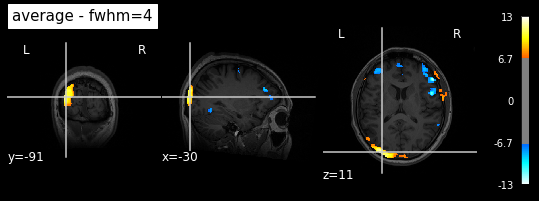

In [21]:
from nilearn.plotting import plot_stat_map
%matplotlib inline
anatimg = find_modality('T1', workdir)
tcont = f'{workdir}/result/spmT_0001.nii'
plot_stat_map(
    tcont, title='average - fwhm=4',
    bg_img=anatimg, threshold=7, display_mode='ortho');